## Imports and Preliminaries

In [16]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset
from scipy.spatial.distance import cosine
from difflib import SequenceMatcher
import torch
from urllib.request import urlopen
from PIL import Image
import timm
import numpy as np
import optuna

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

## Similarity Metric Functions

In [17]:
def euclidean_similarity(v1, v2):
    """Calculate similarity using Euclidean distance."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 / (1 + np.linalg.norm(v1 - v2))

def cosine_sim(v1, v2):
    """Calculate cosine similarity."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 - cosine(v1, v2)

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets or arrays."""
    a, b = np.asarray(set1).ravel(), np.asarray(set2).ravel()
    a, b = set(a.tolist()), set(b.tolist())
    intersection = len(a & b)
    union = len(a | b)
    return intersection / union if union != 0 else 0

def pearson_correlation(v1, v2):
    """Calculate Pearson correlation coefficient."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return np.corrcoef(v1, v2)[0, 1]

def string_similarity(str1, str2):
    """Calculate string similarity using SequenceMatcher."""
    str1, str2 = str(str1), str(str2)
    return SequenceMatcher(None, str1, str2).ratio()


## PCA tensor mapping

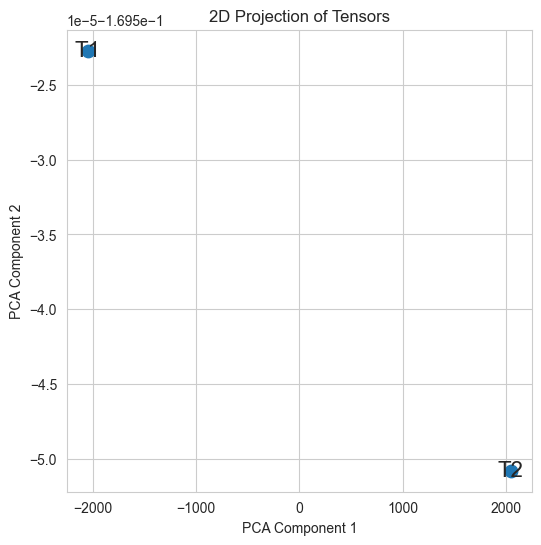

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_tensors_2d(*tensors):
    """
    Takes n tensors of arbitrary dimensionality, flattens them (removing batch dim if 1),
    reduces to 2D using PCA, and plots them on a 2D scatter plot.
    """
    flattened = []
    for t in tensors:
        arr = np.array(t)  # ensure NumPy array
        if arr.ndim > 1 and arr.shape[0] == 1:
            arr = np.squeeze(arr, axis=0)  # remove batch dim if it's 1
        flattened.append(arr.reshape(-1))

    data = np.stack(flattened)
    
    if data.shape[0] < 2:
        raise ValueError("Need at least 2 tensors to perform PCA (n_components=2).")
    
    reduced = PCA(n_components=2).fit_transform(data)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=80)
    for i, (x, y) in enumerate(reduced):
        plt.text(x, y, f"T{i+1}", fontsize=16, ha="center", va="center")
    plt.title("2D Projection of Tensors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()


a = torch.randn(128, 256, 256)
b = torch.randn(128, 256, 256)

plot_tensors_2d(a.numpy(), b.numpy())


## Dataset Class

In [19]:
from pathlib import Path
from PIL import Image
from torchvision import transforms

class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', transform=None):
        """
        Args:
            root_dir: Path to MVTec AD dataset root
            category: Product category (e.g., 'bottle', 'cable', 'capsule')
            split: 'train' or 'test'
            transform: Preprocessing transforms
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        
        # Build image paths
        self.image_paths = []
        self.labels = []
        self.defect_types = []
        
        if split == 'train':
            # Training images are all normal
            train_dir = self.root_dir / category / 'train' / 'good'
            for img_path in sorted(train_dir.glob('*.png')):
                self.image_paths.append(img_path)
                self.labels.append(0)
                self.defect_types.append('good')
        else:
            # Test images include normal and anomalies
            test_dir = self.root_dir / category / 'test'
            for defect_dir in sorted(test_dir.iterdir()):
                if defect_dir.is_dir():
                    defect_type = defect_dir.name
                    label = 0 if defect_type == 'good' else 1
                    for img_path in sorted(defect_dir.glob('*.png')):
                        self.image_paths.append(img_path)
                        self.labels.append(label)
                        self.defect_types.append(defect_type)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.defect_types[idx]


## Create Datasets

In [30]:
from torch.utils.data import ConcatDataset

MVTEC_ROOT = './Dataset' 
CATEGORY = 'cable'
BATCH_SIZE = 500
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ])


transform = get_transforms(IMAGE_SIZE)

all_categories = [
    'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut',
    'leather', 'metal_nut', 'pill', 'screw', 'tile',
    'toothbrush', 'transistor', 'wood', 'zipper'
]

train_datasets = [
    MVTecDataset(root_dir=MVTEC_ROOT, category=cat, split="train", transform=transform)
    for cat in all_categories
]

train_dataset = ConcatDataset(train_datasets)

test_datasets = [
    MVTecDataset(root_dir=MVTEC_ROOT, category=cat, split="test", transform=transform)
    for cat in all_categories
]

test_dataset = ConcatDataset(test_datasets)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

TRAINING IMAGES


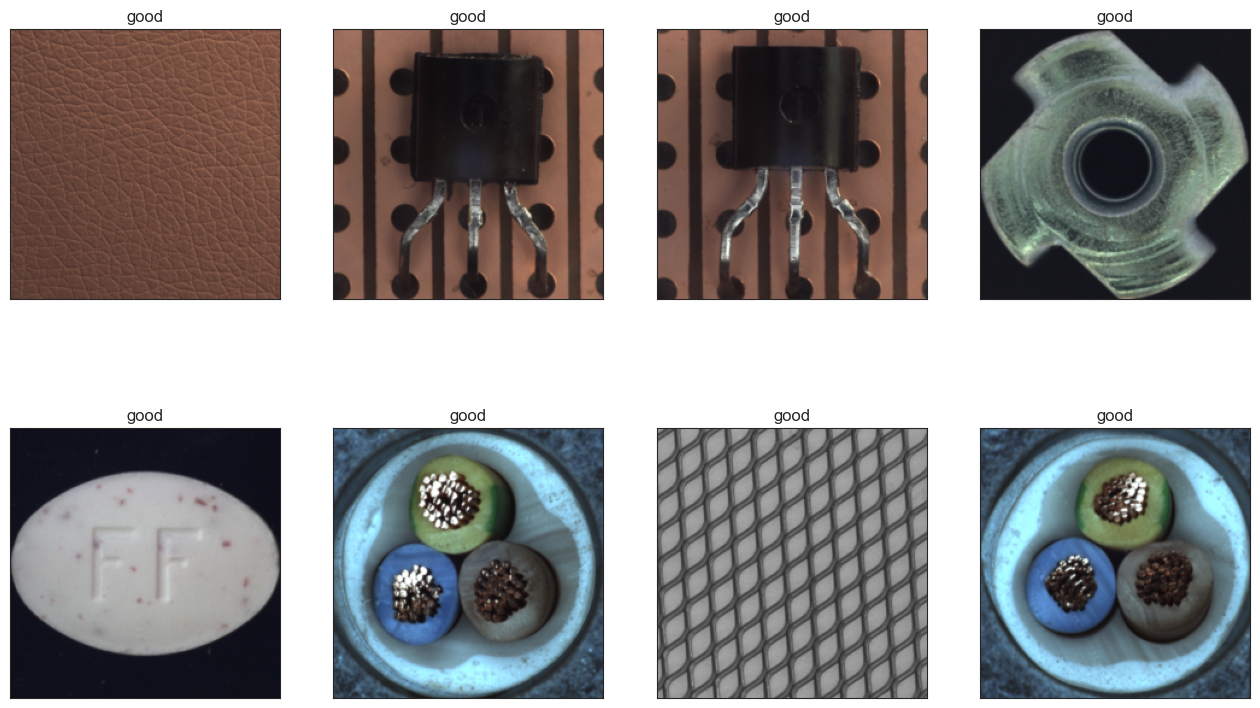

TESTING IMAGES


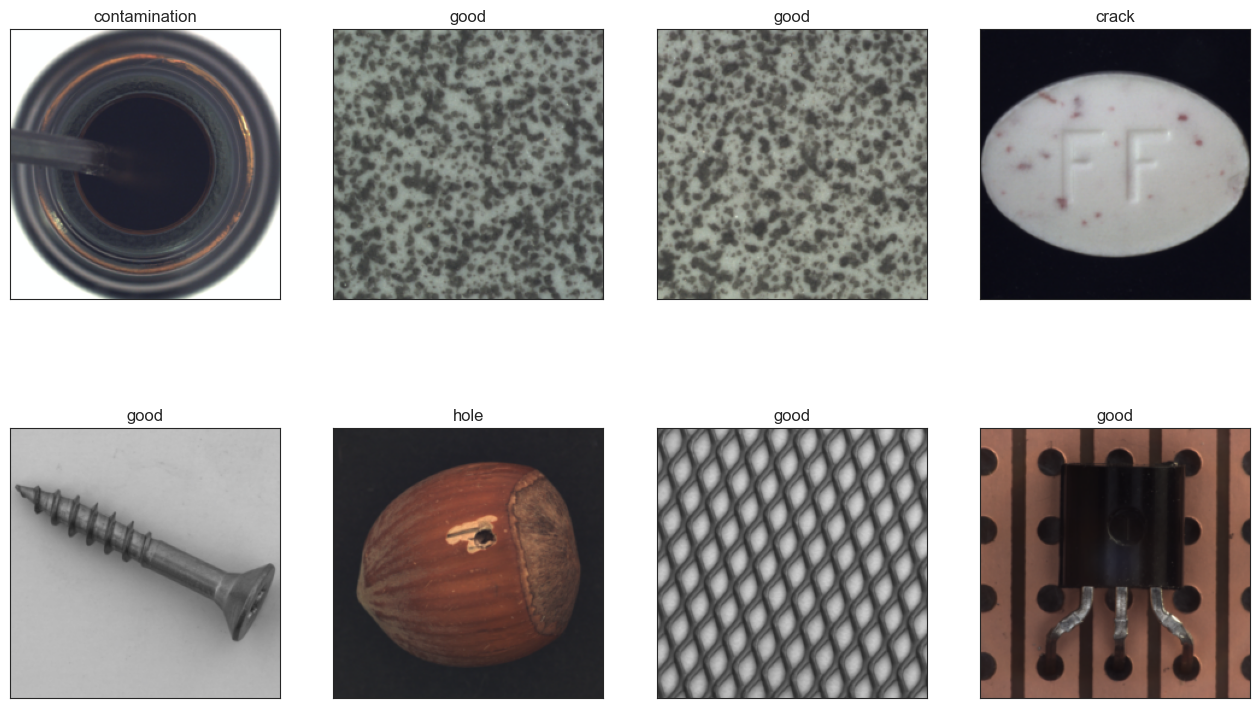

In [21]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
      fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:8], labels[:8])):
        plt.sca(axes[j])
        show_image(img, label)
    plt.show()

def show_dataset_all_labels(dataloader):
  images, labels = next(iter(dataloader))
  i = 0
  for j, (img, label) in enumerate(zip(images, labels)):
      print(f"{label} is image {i}")
      i+= 1

print("TRAINING IMAGES")
show_dataset_examples(train_loader)
print("TESTING IMAGES")
show_dataset_examples(test_loader)

## Add DINO using TIMM for Visualization

In [22]:
import torch
from urllib.request import urlopen
from PIL import Image
import timm
import torchvision.transforms as T

def embed_and_plot_from_loader(dataloader, max_images=8, model_url = "vit_small_patch16_dinov3_qkvb.lvd1689m"):
    # Load model
    model = timm.create_model(model_url, pretrained=True)
    model.eval()

    # Preprocessing (timm's eval pipeline) + tensor->PIL converter
    data_config = timm.data.resolve_model_data_config(model)
    preprocess = timm.data.create_transform(**data_config, is_training=False)
    to_pil = T.ToPILImage()

    # Take one batch from the loader
    images, _ = next(iter(dataloader))

    embeddings = []
    for img in images[:max_images]:
        # Ensure PIL for timm transforms
        if isinstance(img, torch.Tensor):
            img = to_pil(img)

        x = preprocess(img).unsqueeze(0)

        with torch.no_grad():
            feats = model.forward_features(x)
            if isinstance(feats, dict):
                emb = feats.get('x_norm_clstoken') or feats.get('x_norm')
            else:
                emb = feats

        embeddings.append(emb.squeeze(0).numpy())

    # Plot
    if len(embeddings) >= 2:
        plot_tensors_2d(*embeddings)
    else:
        print("Need at least 2 images to plot.")


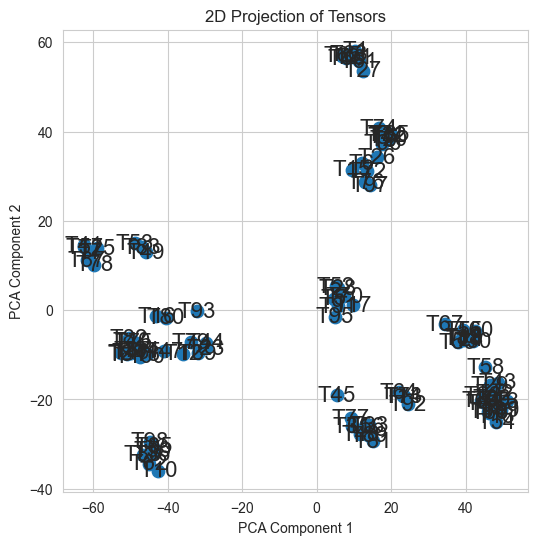

In [23]:
embed_and_plot_from_loader(train_loader, max_images=300)

## Embed training features, compare to Test data and draw conclusion

In [24]:
def embed_and_save_features(dataloader, model_url = "vit_small_patch16_dinov3_qkvb.lvd1689m"):
    # Load model
    model = timm.create_model(model_url, pretrained=True)
    model.eval()

    # Preprocessing (timm's eval pipeline) + tensor->PIL converter
    data_config = timm.data.resolve_model_data_config(model)
    preprocess = timm.data.create_transform(**data_config, is_training=False)
    to_pil = T.ToPILImage()

    # Take one batch from the loader
    images, labels = next(iter(dataloader))

    embeddings = []
    for (img, label) in zip(images, labels):
        # Ensure PIL for timm transforms
        if isinstance(img, torch.Tensor):
            img = to_pil(img)

        x = preprocess(img).unsqueeze(0)

        with torch.no_grad():
            feats = model.forward_features(x)
            if isinstance(feats, dict):
                emb = feats.get('x_norm_clstoken') or feats.get('x_norm')
            else:
                emb = feats

        embeddings.append((emb.squeeze(0).numpy(), label))

    return embeddings



In [31]:
import numpy as np
import csv

def compare_similarities_vecs(test_vec, gt_vecs, sim_func):
    """Compute similarity between one test vector and many GT vectors."""
    tv = np.asarray(test_vec).ravel()
    sims = []
    for g in gt_vecs:
        gv = np.asarray(g).ravel()
        if tv.shape[0] != gv.shape[0]:
            raise ValueError(f"Dim mismatch: test D={tv.shape[0]} vs GT D={gv.shape[0]}")
        sims.append(sim_func(tv, gv))
    return np.array(sims)

embeddings_GT = embed_and_save_features(train_loader)   # [(embedding, label), ...]
embeddings_Test = embed_and_save_features(test_loader)   # [(embedding, label), ...]

def compare_and_draw_conclusion(threshold=0.8, percentile: float=0.1, csv_path="results.csv"):
    """
    - percentile: float between 0 and 1 indicating which percentile similarity to use.
    - Uses the `rank`-th best similarity (default: 10th).
    - Predicts 'good' if that similarity > threshold, else 'anomalous'.
    - Saves all test case results and final accuracy to a CSV file.
    """



    gt_embeddings, _ = zip(*embeddings_GT) if len(embeddings_GT) else ([], [])

    #results = []
    correct = 0
    total = 0

    for test_embedding, label in embeddings_Test:
        similarities = compare_similarities_vecs(test_embedding, gt_embeddings, cosine_sim)
        sorted_sims = np.sort(similarities)[::-1]  # descending order

        # Pick the rank-th best if available, otherwise use the last one
        rank  = int(percentile * len(sorted_sims))
        selected_score = sorted_sims[rank - 1] if len(sorted_sims) >= rank else sorted_sims[-1]

        # Decision
        predicted_label = "good" if selected_score > threshold else "anomalous"
        true_label = "good" if str(label).lower() == "good" else "anomalous"

        # Count accuracy
        is_correct = int(predicted_label == true_label)
        correct += is_correct
        total += 1

        # # Store result
        # results.append({
        #     "Test_Index": total,
        #     "True_Label": true_label,
        #     "Predicted_Label": predicted_label,
        #     f"{rank}th_Best_Similarity": selected_score,
        #     "Correct": is_correct
        # })

    accuracy = correct / total if total else 0
    # results.append({
    #     "Test_Index": "TOTAL",
    #     "True_Label": "",
    #     "Predicted_Label": "",
    #     f"{rank}th_Best_Similarity": "",
    #     "Correct": f"{accuracy*100:.2f}% ({correct}/{total})"
    # })

    #print(f"Results saved to {csv_path}")
    return accuracy


HYPER PARAM TUNNING

In [ ]:
import optuna
from tqdm import tqdm

# Your objective function
def objective(trial):
    # 1. Suggest hyperparameters
    percentile = trial.suggest_float("percentile", 0.0, 1.0)
    threshold = trial.suggest_float("threshold", 0.4, 1.0)

    # 2. Evaluate your model with those parameters
    score = compare_and_draw_conclusion(
        percentile=percentile, 
        threshold=threshold
    )

    # 3. Return what you want to maximize
    return score

# Create a study
study = optuna.create_study(direction="maximize")

# Number of trials
n_trials = 50

# Run trials manually with tqdm
for _ in tqdm(range(n_trials), desc="Optimizing hyperparameters"):
    trial = study.ask()                 # Ask for a new trial
    score = objective(trial)            # Evaluate objective
    study.tell(trial, score)            # Tell Optuna the result

# Print best results
print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)


[I 2025-11-17 16:50:40,040] A new study created in memory with name: no-name-687922a5-7d23-45fa-8421-732b52e2ba38
Optimizing hyperparameters:   6%|▌         | 3/50 [02:23<37:29, 47.85s/it]

Number of trials: 50
Number of completed trials: 50
Number of pruned trials: 0

Best trial:
  Value: 0.71
  Params: {'percentile': 0.7090769013217701, 'threshold': 0.6712179886730916}

All completed trials:
Trial 0: value=0.71, params={'percentile': 0.7090769013217701, 'threshold': 0.6712179886730916}
Trial 1: value=0.29, params={'percentile': 0.2664353849153581, 'threshold': 0.41734199231374336}
Trial 2: value=0.35, params={'percentile': 0.37414504429460393, 'threshold': 0.534578908419173}
Trial 3: value=0.71, params={'percentile': 0.7174786438759285, 'threshold': 0.6734852865104825}
Trial 4: value=0.71, params={'percentile': 0.2546249736969731, 'threshold': 0.8668156968492737}
Trial 5: value=0.71, params={'percentile': 0.7797923940016874, 'threshold': 0.7587634618135837}
Trial 6: value=0.29, params={'percentile': 0.10927319084478992, 'threshold': 0.4760582127198686}
Trial 7: value=0.35, params={'percentile': 0.1715739305130607, 'threshold': 0.6276226351062129}
Trial 8: value=0.29, pa

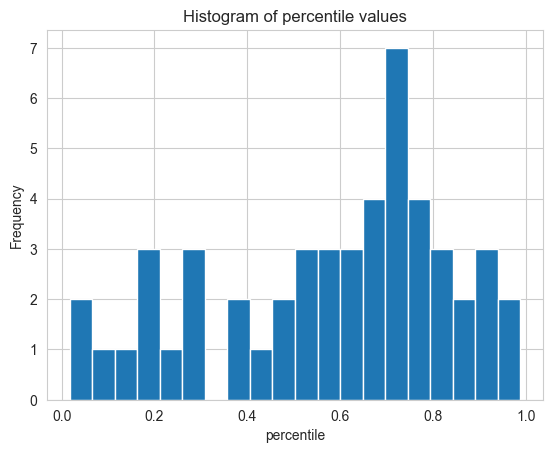

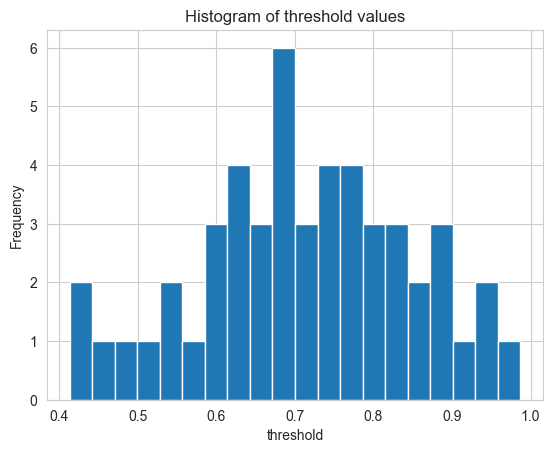

In [ ]:
import optuna
import optuna.visualization as vis
from optuna.trial import TrialState
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Optional: Create directory for saving figures
SAVE_FIGS = True
OUTPUT_DIR = Path("optuna_analysis")
if SAVE_FIGS:
    OUTPUT_DIR.mkdir(exist_ok=True)

# ============================================================================
# 📊 1. STUDY OVERVIEW & STATISTICS
# ============================================================================
print("="*80)
print("OPTUNA STUDY ANALYSIS REPORT")
print("="*80)

# Basic statistics
total_trials = len(study.trials)
completed_trials = len([t for t in study.trials if t.state == TrialState.COMPLETE])
pruned_trials = len([t for t in study.trials if t.state == TrialState.PRUNED])
failed_trials = len([t for t in study.trials if t.state == TrialState.FAIL])

print(f"\n📈 Study Overview:")
print(f"   Total trials: {total_trials}")
print(f"   ✓ Completed: {completed_trials} ({completed_trials/total_trials*100:.1f}%)")
print(f"   ✂ Pruned: {pruned_trials} ({pruned_trials/total_trials*100:.1f}%)")
print(f"   ✗ Failed: {failed_trials} ({failed_trials/total_trials*100:.1f}%)")
print(f"   Direction: {study.direction.name}")

# Best trial information
if completed_trials > 0:
    best_trial = study.best_trial
    print(f"\n🏆 Best Trial (#{best_trial.number}):")
    print(f"   Value: {best_trial.value:.6f}")
    print(f"   Parameters:")
    for param, value in best_trial.params.items():
        print(f"      {param}: {value}")
    
    # Additional best trial info
    print(f"   Duration: {best_trial.duration}")
    print(f"   DateTime: {best_trial.datetime_start}")

# ============================================================================
# 📊 2. STATISTICAL SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("📊 STATISTICAL SUMMARY")
print("="*80)

# Get completed trials DataFrame
trials_df = study.trials_dataframe()
completed_df = trials_df[trials_df['state'] == 'COMPLETE']

if len(completed_df) > 0:
    # Objective value statistics
    print(f"\nObjective Value Statistics:")
    print(f"   Mean: {completed_df['value'].mean():.6f}")
    print(f"   Std: {completed_df['value'].std():.6f}")
    print(f"   Min: {completed_df['value'].min():.6f}")
    print(f"   25%: {completed_df['value'].quantile(0.25):.6f}")
    print(f"   Median: {completed_df['value'].median():.6f}")
    print(f"   75%: {completed_df['value'].quantile(0.75):.6f}")
    print(f"   Max: {completed_df['value'].max():.6f}")
    
    # Parameter statistics
    param_cols = [col for col in completed_df.columns if col.startswith('params_')]
    
    if param_cols:
        print(f"\nParameter Statistics:")
        for param_col in param_cols:
            param_name = param_col.replace('params_', '')
            print(f"\n   {param_name}:")
            print(f"      Mean: {completed_df[param_col].mean():.6f}")
            print(f"      Std: {completed_df[param_col].std():.6f}")
            print(f"      Min: {completed_df[param_col].min():.6f}")
            print(f"      Max: {completed_df[param_col].max():.6f}")
    
    # Top N trials
    N = min(5, len(completed_df))
    print(f"\n🥇 Top {N} Trials:")
    top_trials = completed_df.nsmallest(N, 'value') if study.direction == optuna.study.StudyDirection.MINIMIZE else completed_df.nlargest(N, 'value')
    
    for idx, (_, trial) in enumerate(top_trials.iterrows(), 1):
        print(f"\n   {idx}. Trial #{int(trial['number'])}")
        print(f"      Value: {trial['value']:.6f}")
        for param_col in param_cols:
            param_name = param_col.replace('params_', '')
            print(f"      {param_name}: {trial[param_col]}")

# ============================================================================
# 📊 3. OPTUNA BUILT-IN VISUALIZATIONS
# ============================================================================
print(f"\n{'='*80}")
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

if completed_trials > 0:
    # 3.1 Optimization History
    print("\n1. Creating optimization history plot...")
    fig1 = vis.plot_optimization_history(study)
    fig1.update_layout(
        title="Optimization History",
        width=1000,
        height=500
    )
    if SAVE_FIGS:
        fig1.write_html(OUTPUT_DIR / "01_optimization_history.html")
    fig1.show()
    
    # 3.2 Parameter Importances
    if completed_trials >= 3:  # Need at least 3 trials for importance
        print("2. Creating parameter importance plot...")
        try:
            fig2 = vis.plot_param_importances(study)
            fig2.update_layout(
                title="Hyperparameter Importance",
                width=800,
                height=500
            )
            if SAVE_FIGS:
                fig2.write_html(OUTPUT_DIR / "02_param_importances.html")
            fig2.show()
        except Exception as e:
            print(f"   ⚠ Could not create importance plot: {e}")
    
    # 3.3 Parallel Coordinate Plot
    if len(param_cols) > 0:
        print("3. Creating parallel coordinate plot...")
        fig3 = vis.plot_parallel_coordinate(study)
        fig3.update_layout(
            title="Parallel Coordinate Plot",
            width=1200,
            height=600
        )
        if SAVE_FIGS:
            fig3.write_html(OUTPUT_DIR / "03_parallel_coordinate.html")
        fig3.show()
    
    # 3.4 Contour Plots (for pairs of parameters)
    if len(param_cols) >= 2:
        print("4. Creating contour plots...")
        param_names = [col.replace('params_', '') for col in param_cols[:2]]
        try:
            fig4 = vis.plot_contour(study, params=param_names)
            fig4.update_layout(
                title=f"Contour Plot: {param_names[0]} vs {param_names[1]}",
                width=900,
                height=600
            )
            if SAVE_FIGS:
                fig4.write_html(OUTPUT_DIR / "04_contour.html")
            fig4.show()
        except Exception as e:
            print(f"   ⚠ Could not create contour plot: {e}")
    
    # 3.5 Slice Plot
    print("5. Creating slice plot...")
    fig5 = vis.plot_slice(study)
    fig5.update_layout(
        title="Slice Plot (Individual Parameter Effects)",
        width=1200,
        height=400 * len(param_cols)
    )
    if SAVE_FIGS:
        fig5.write_html(OUTPUT_DIR / "05_slice.html")
    fig5.show()
    
    # 3.6 EDF (Empirical Distribution Function)
    print("6. Creating EDF plot...")
    fig6 = vis.plot_edf(study)
    fig6.update_layout(
        title="Empirical Distribution Function",
        width=900,
        height=500
    )
    if SAVE_FIGS:
        fig6.write_html(OUTPUT_DIR / "06_edf.html")
    fig6.show()

# ============================================================================
# 📊 4. CUSTOM MATPLOTLIB VISUALIZATIONS
# ============================================================================
print(f"\n{'='*80}")
print("📊 CREATING CUSTOM VISUALIZATIONS")
print("="*80)

if len(completed_df) > 0:
    # 4.1 Enhanced Optimization History with Confidence Bands
    print("\n1. Creating enhanced optimization history...")
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot all trials
    ax.scatter(completed_df['number'], completed_df['value'], 
               alpha=0.6, s=50, label='Trial value', c='steelblue')
    
    # Plot best value so far
    if study.direction == optuna.study.StudyDirection.MINIMIZE:
        best_values = completed_df['value'].cummin()
    else:
        best_values = completed_df['value'].cummax()
    
    ax.plot(completed_df['number'], best_values, 
            'r-', linewidth=2, label='Best value', marker='o', markersize=4)
    
    # Add rolling mean
    if len(completed_df) >= 10:
        rolling_mean = completed_df['value'].rolling(window=10, min_periods=1).mean()
        ax.plot(completed_df['number'], rolling_mean, 
                'g--', linewidth=2, alpha=0.7, label='Rolling mean (10 trials)')
    
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('Objective Value', fontsize=12)
    ax.set_title('Optimization Progress Over Time', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if SAVE_FIGS:
        plt.savefig(OUTPUT_DIR / "07_custom_optimization_history.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4.2 Parameter Distribution Histograms
    if param_cols:
        print("2. Creating parameter distribution plots...")
        n_params = len(param_cols)
        fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))
        if n_params == 1:
            axes = [axes]
        
        for ax, param_col in zip(axes, param_cols):
            param_name = param_col.replace('params_', '')
            
            # Histogram
            ax.hist(completed_df[param_col], bins=20, alpha=0.7, 
                   color='steelblue', edgecolor='black')
            
            # Add mean line
            mean_val = completed_df[param_col].mean()
            ax.axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.3f}')
            
            # Add best value line
            best_val = best_trial.params[param_name]
            ax.axvline(best_val, color='green', linestyle='--', 
                      linewidth=2, label=f'Best: {best_val:.3f}')
            
            ax.set_xlabel(param_name, fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'Distribution of {param_name}', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(OUTPUT_DIR / "08_parameter_distributions.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4.3 Correlation Heatmap
    if len(param_cols) > 1:
        print("3. Creating correlation heatmap...")
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Select parameter columns and objective value
        corr_cols = param_cols + ['value']
        corr_df = completed_df[corr_cols].copy()
        corr_df.columns = [col.replace('params_', '') for col in corr_cols]
        
        # Calculate correlation
        corr_matrix = corr_df.corr()
        
        # Create heatmap
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        
        ax.set_title('Parameter Correlation Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if SAVE_FIGS:
            plt.savefig(OUTPUT_DIR / "09_correlation_heatmap.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4.4 Scatter matrix for parameters vs objective
    if len(param_cols) >= 2:
        print("4. Creating scatter matrix...")
        n_params = min(len(param_cols), 4)  # Limit to 4 params for readability
        selected_params = param_cols[:n_params]
        
        fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 5))
        if n_params == 1:
            axes = [axes]
        
        for ax, param_col in zip(axes, selected_params):
            param_name = param_col.replace('params_', '')
            
            # Scatter plot with color based on objective value
            scatter = ax.scatter(completed_df[param_col], completed_df['value'],
                               c=completed_df['value'], cmap='viridis', 
                               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
            
            # Highlight best trial
            best_idx = completed_df['value'].idxmin() if study.direction == optuna.study.StudyDirection.MINIMIZE else completed_df['value'].idxmax()
            ax.scatter(completed_df.loc[best_idx, param_col], 
                      completed_df.loc[best_idx, 'value'],
                      c='red', s=200, marker='*', edgecolors='black', 
                      linewidth=2, label='Best trial', zorder=5)
            
            ax.set_xlabel(param_name, fontsize=11)
            ax.set_ylabel('Objective Value', fontsize=11)
            ax.set_title(f'{param_name} vs Objective', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add colorbar
            plt.colorbar(scatter, ax=ax, label='Objective Value')
        
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(OUTPUT_DIR / "10_scatter_matrix.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4.5 Trial Duration Analysis
    if 'duration' in completed_df.columns:
        print("5. Creating trial duration analysis...")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Convert duration to seconds
        durations = completed_df['duration'].dt.total_seconds()
        
        # Duration over trials
        ax1.plot(completed_df['number'], durations, marker='o', 
                linestyle='-', alpha=0.6, color='steelblue')
        ax1.set_xlabel('Trial Number', fontsize=11)
        ax1.set_ylabel('Duration (seconds)', fontsize=11)
        ax1.set_title('Trial Duration Over Time', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Duration histogram
        ax2.hist(durations, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        ax2.axvline(durations.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {durations.mean():.2f}s')
        ax2.set_xlabel('Duration (seconds)', fontsize=11)
        ax2.set_ylabel('Frequency', fontsize=11)
        ax2.set_title('Distribution of Trial Durations', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(OUTPUT_DIR / "11_duration_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# 📊 5. CONVERGENCE ANALYSIS
# ============================================================================
print(f"\n{'='*80}")
print("📊 CONVERGENCE ANALYSIS")
print("="*80)

if len(completed_df) >= 10:
    print("\nAnalyzing convergence...")
    
    # Calculate improvement rate
    values = completed_df['value'].values
    improvements = []
    for i in range(1, len(values)):
        if study.direction == optuna.study.StudyDirection.MINIMIZE:
            improvement = max(0, values[i-1] - values[i])
        else:
            improvement = max(0, values[i] - values[i-1])
        improvements.append(improvement)
    
    # Recent improvements
    recent_window = min(10, len(improvements))
    recent_improvements = improvements[-recent_window:]
    avg_recent_improvement = np.mean(recent_improvements)
    
    print(f"\n   Average improvement (last {recent_window} trials): {avg_recent_improvement:.6f}")
    
    if avg_recent_improvement < 1e-6:
        print("   ⚠ Optimization may have converged (very small improvements)")
    elif len(completed_df) < 50:
        print("   ℹ Consider running more trials for better convergence")
    else:
        print("   ✓ Optimization appears to be progressing")

# ============================================================================
# 📊 6. EXPORT RESULTS
# ============================================================================
print(f"\n{'='*80}")
print("💾 EXPORTING RESULTS")
print("="*80)

if SAVE_FIGS:
    # Save trials dataframe
    trials_df.to_csv(OUTPUT_DIR / "trials_data.csv", index=False)
    print(f"\n✓ Trials data saved to: {OUTPUT_DIR / 'trials_data.csv'}")
    
    # Save best parameters
    if completed_trials > 0:
        with open(OUTPUT_DIR / "best_parameters.txt", 'w') as f:
            f.write(f"Best Trial: #{best_trial.number}\n")
            f.write(f"Best Value: {best_trial.value}\n\n")
            f.write("Best Parameters:\n")
            for param, value in best_trial.params.items():
                f.write(f"  {param}: {value}\n")
        print(f"✓ Best parameters saved to: {OUTPUT_DIR / 'best_parameters.txt'}")
    
    print(f"✓ All visualizations saved to: {OUTPUT_DIR}")

print(f"\n{'='*80}")
print("✅ ANALYSIS COMPLETE")
print("="*80)

In [ ]:
compare_and_draw_conclusion(threshold=0.86, rank=7)

TypeError: can only concatenate list (not "tuple") to list